In [1]:
import pandas as pd
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
import cmdstanpy as stan
import seaborn as sns
import arviz as az
# import arviz.labels as azl

ModuleNotFoundError: No module named 'arviz.labels'

In [5]:
%load_ext stanmagic
# Don't sting my eyes
%config InlineBackend.figure_format = 'retina'
sns.set()

The stanmagic extension is already loaded. To reload it, use:
  %reload_ext stanmagic


In [7]:
%%stan -f sparse_model.stan -v model --stanc ~/.cmdstan/cmdstan-2.26.1/bin/stanc
functions{
  matrix squared_exp(int N, int P, matrix dist_mat, real l, real sigmasq){
    matrix[N,P] ret = sigmasq * exp(-0.5 * dist_mat / l^2);
    return(ret);
  }
  vector M(vector x, real b){
    return 1 - exp(- b * x);
  }
  real M_real(real x, real b){
    return 1 - exp(- b * x);
  }
  real softplus(real x) {
      return log(1 + exp(x));
  }
  vector softplus_vec(vector x) {
      return log(1 + exp(x));
  }
}
data {
  int<lower=0> N;
  int<lower=0> N_eval;
  vector<lower=0, upper=1>[N] p0;
  vector[N] x0;
  vector<lower=0, upper=1>[N] p1;
  vector[N] x1;
  int<lower=0, upper=1> chose1[N];
  real prior_shape;
  real prior_rate;
  // real<lower = 0> l; // possibly parameter
  // real<lower = 0> sigmasq; //possibly parameter
  vector[N_eval] x_eval;
  real jitter;
  //real beta;
}
transformed data {

}
parameters {
  vector[N_eval] z; //inducing points style
  real beta_unc;
  real<lower = 0> l; //hyperparameter
  real<lower = 0> sigmasq; //hyperparameter
}
transformed parameters{
  real beta = softplus(beta_unc);
  vector[N_eval] r;
  matrix[N_eval, N_eval] K;
  cholesky_factor_cov[N_eval] K_chol;
  K = gp_exp_quad_cov(to_array_1d(x_eval), sigmasq, l) + diag_matrix(rep_vector(jitter, N_eval));
  K_chol = cholesky_decompose(K);
  //if not positive, then divergence happens (this restricts that the correction near 0 is really small)
  r = softplus_vec(K_chol * z + rep_vector(0.5, N_eval)); // GP(1, K)
}
model {
  vector[N] seu0;
  vector[N] seu1;
  vector[N] r0_pred;
  vector[N] r1_pred;
  //to the model or params if we wish to infer the hyperparameters
  matrix[N_eval, N_eval] K_inv;
  matrix[N_eval, N_eval] K_chol_inv;
  matrix[N, N_eval] K0;
  matrix[N, N_eval] K1;

  K_inv = inverse_spd(K);
  K0 = gp_exp_quad_cov(to_array_1d(x0), to_array_1d(x_eval), sigmasq, l);
  K1 = gp_exp_quad_cov(to_array_1d(x1), to_array_1d(x_eval), sigmasq, l);

  //could use softplus_vec to map to positive GPs to retain monotonicity (does it go like this?)
  //mean prediction of GP p(f | f_eval) (remember that prior mean is 1.0)
  r0_pred = 1.0 + K0 * K_inv * (r - 1.0);
  r1_pred = 1.0 + K1 * K_inv * (r - 1.0);

  seu0 = p0 .* M(x0, beta) .* r0_pred;
  seu1 = p1 .* M(x1, beta) .* r1_pred;
  //prior
  beta ~ gamma(prior_shape, prior_rate);
  z ~ normal(0,1);//Gp prior
  l ~ inv_gamma(5,6);
  sigmasq ~ normal(0, 2);
  //likelihood
  chose1 ~ bernoulli_logit(seu1 - seu0);
}

Using stanc compiler:  ~/.cmdstan/cmdstan-2.26.1/bin/stanc
~/.cmdstan/cmdstan-2.26.1/bin/stanc --o=/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/ffd48912-9d74-4e1a-8e72-0cd643c22723.cpp sparse_model.stan

-------------------------------------------------------------------------------
Model compiled successfully. Output stored in model object.
Type model in a cell to see a nicely formatted code output in a notebook
     ^^^^^
Access model compile output properties
model.model_file -> Name of stan_file [sparse_model.stan]
model.model_name -> Name of stan model [sparse_model_model]
model.model_code -> Model code [functions{   matrix  ....]


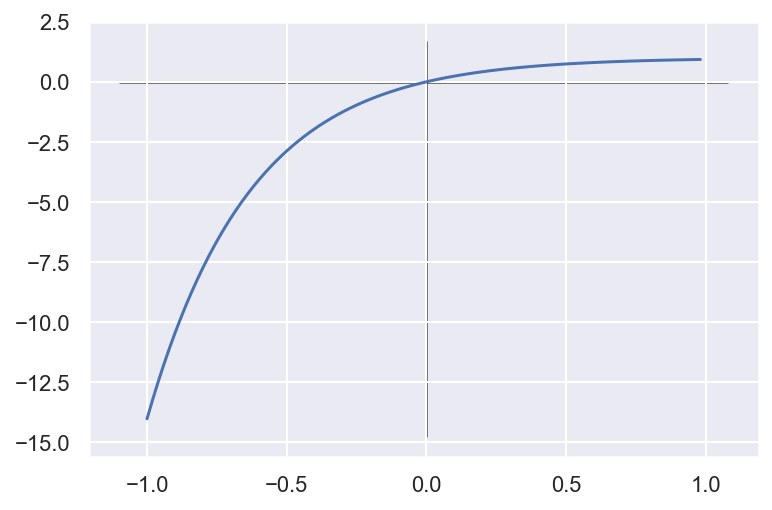

In [16]:
beta_real = 2.71
def u_data(x): return 1 - np.exp(-beta_real*x)
xx = np.arange(-1,1, 0.02)
plt.plot(xx, u_data(xx))
axes = plt.gca()
y_min, y_max = axes.get_ylim()
x_min, x_max = axes.get_xlim()
plt.hlines(0, x_min, x_max, color='black', alpha=0.5, zorder=-1)
plt.vlines(0, y_min, y_max, color='black', alpha=0.5, zorder=-1);

In [17]:
seed=1234 
n=550
u = u_data
np.random.seed(seed)
N_pool = 8000
task = pd.DataFrame(index=np.zeros(N_pool), columns=["p0", "x0", "p1", "x1"])
task["x0"] = np.random.uniform(-2, 2, N_pool)
task["x1"] = np.random.uniform(-2, 2, N_pool)
task["p0"] = np.random.uniform(0, 1, N_pool)
task["p1"] = np.random.uniform(0, 1, N_pool)
task = task[~((task.p0 >= task.p1) & (task.x0 >= task.x1))]
task = task[~((task.p1 >= task.p0) & (task.x1 >= task.x0))]

seu0 = task.p0 * u(task.x0)
seu1 = task.p1 * u(task.x1)

diff_eu = seu1 - seu0

p_choice_1 = expit(1.0*diff_eu) # this is probability of choosing 1 
choice = np.zeros(p_choice_1.shape, dtype=int)
choice[:] = p_choice_1 > np.random.uniform(size=choice.shape)
task["choice"] = choice

task = task.sample(n=n, replace=False)
#task = task.sort_values(by="diff_eu")
#task.reset_index(inplace=True, drop=True)

p0 = task.p0.values
p1 = task.p1.values
x0 = task.x0.values
x1 = task.x1.values
choices = task.choice.values

In [20]:
stan_model = stan.CmdStanModel(stan_file=model.model_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/aureliennioche/Documents/PythonProjects/CogModelDiscrepancy/sparse_model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/aureliennioche/Documents/PythonProjects/CogModelDiscrepancy/sparse_model


In [24]:
#introduce things regarded to GP
l = 1.5
sigmasq = 1.0
N_eval = 26
x_eval = np.linspace(-3,3, N_eval)

prior_shape = 1.5
prior_rate = 0.99
stan_data = {"N": len(p0),
             "N_eval": N_eval,
             "p0": p0,
             "x0": x0,
             "p1": p1,
             "x1": x1,
             "chose1": choices,
             "prior_shape": prior_shape,
             "prior_rate": prior_rate,
             "x_eval": x_eval,
            #  "l": l,
            #  "sigmasq": sigmasq,
            #  "beta": beta_real/2,
             "jitter": 1e-8}

In [25]:
samples = stan_model.sample(data=stan_data, show_progress="notebook", chains=4)

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [51]:
samp = samples.draws(concat_chains=True)

In [52]:
samples_az = az.from_cmdstanpy(samples)

In [56]:
samples.stan_variable("r").shape

(4000, 26)

In [34]:
r_samples = samples_az.posterior["r"]
r_samples.shape

(4, 1000, 26)

In [35]:
x_eval.shape

(26,)

In [37]:
r_samples.mean(axis=0).mean(axis=0).shape

(26,)

In [58]:
r_mean = samples.stan_variable("r").mean(axis=0) #r_samples.mean(axis=0)
r_median = np.median(samples.stan_variable("r"), axis=0) #np.median(r_samples, axis=0)

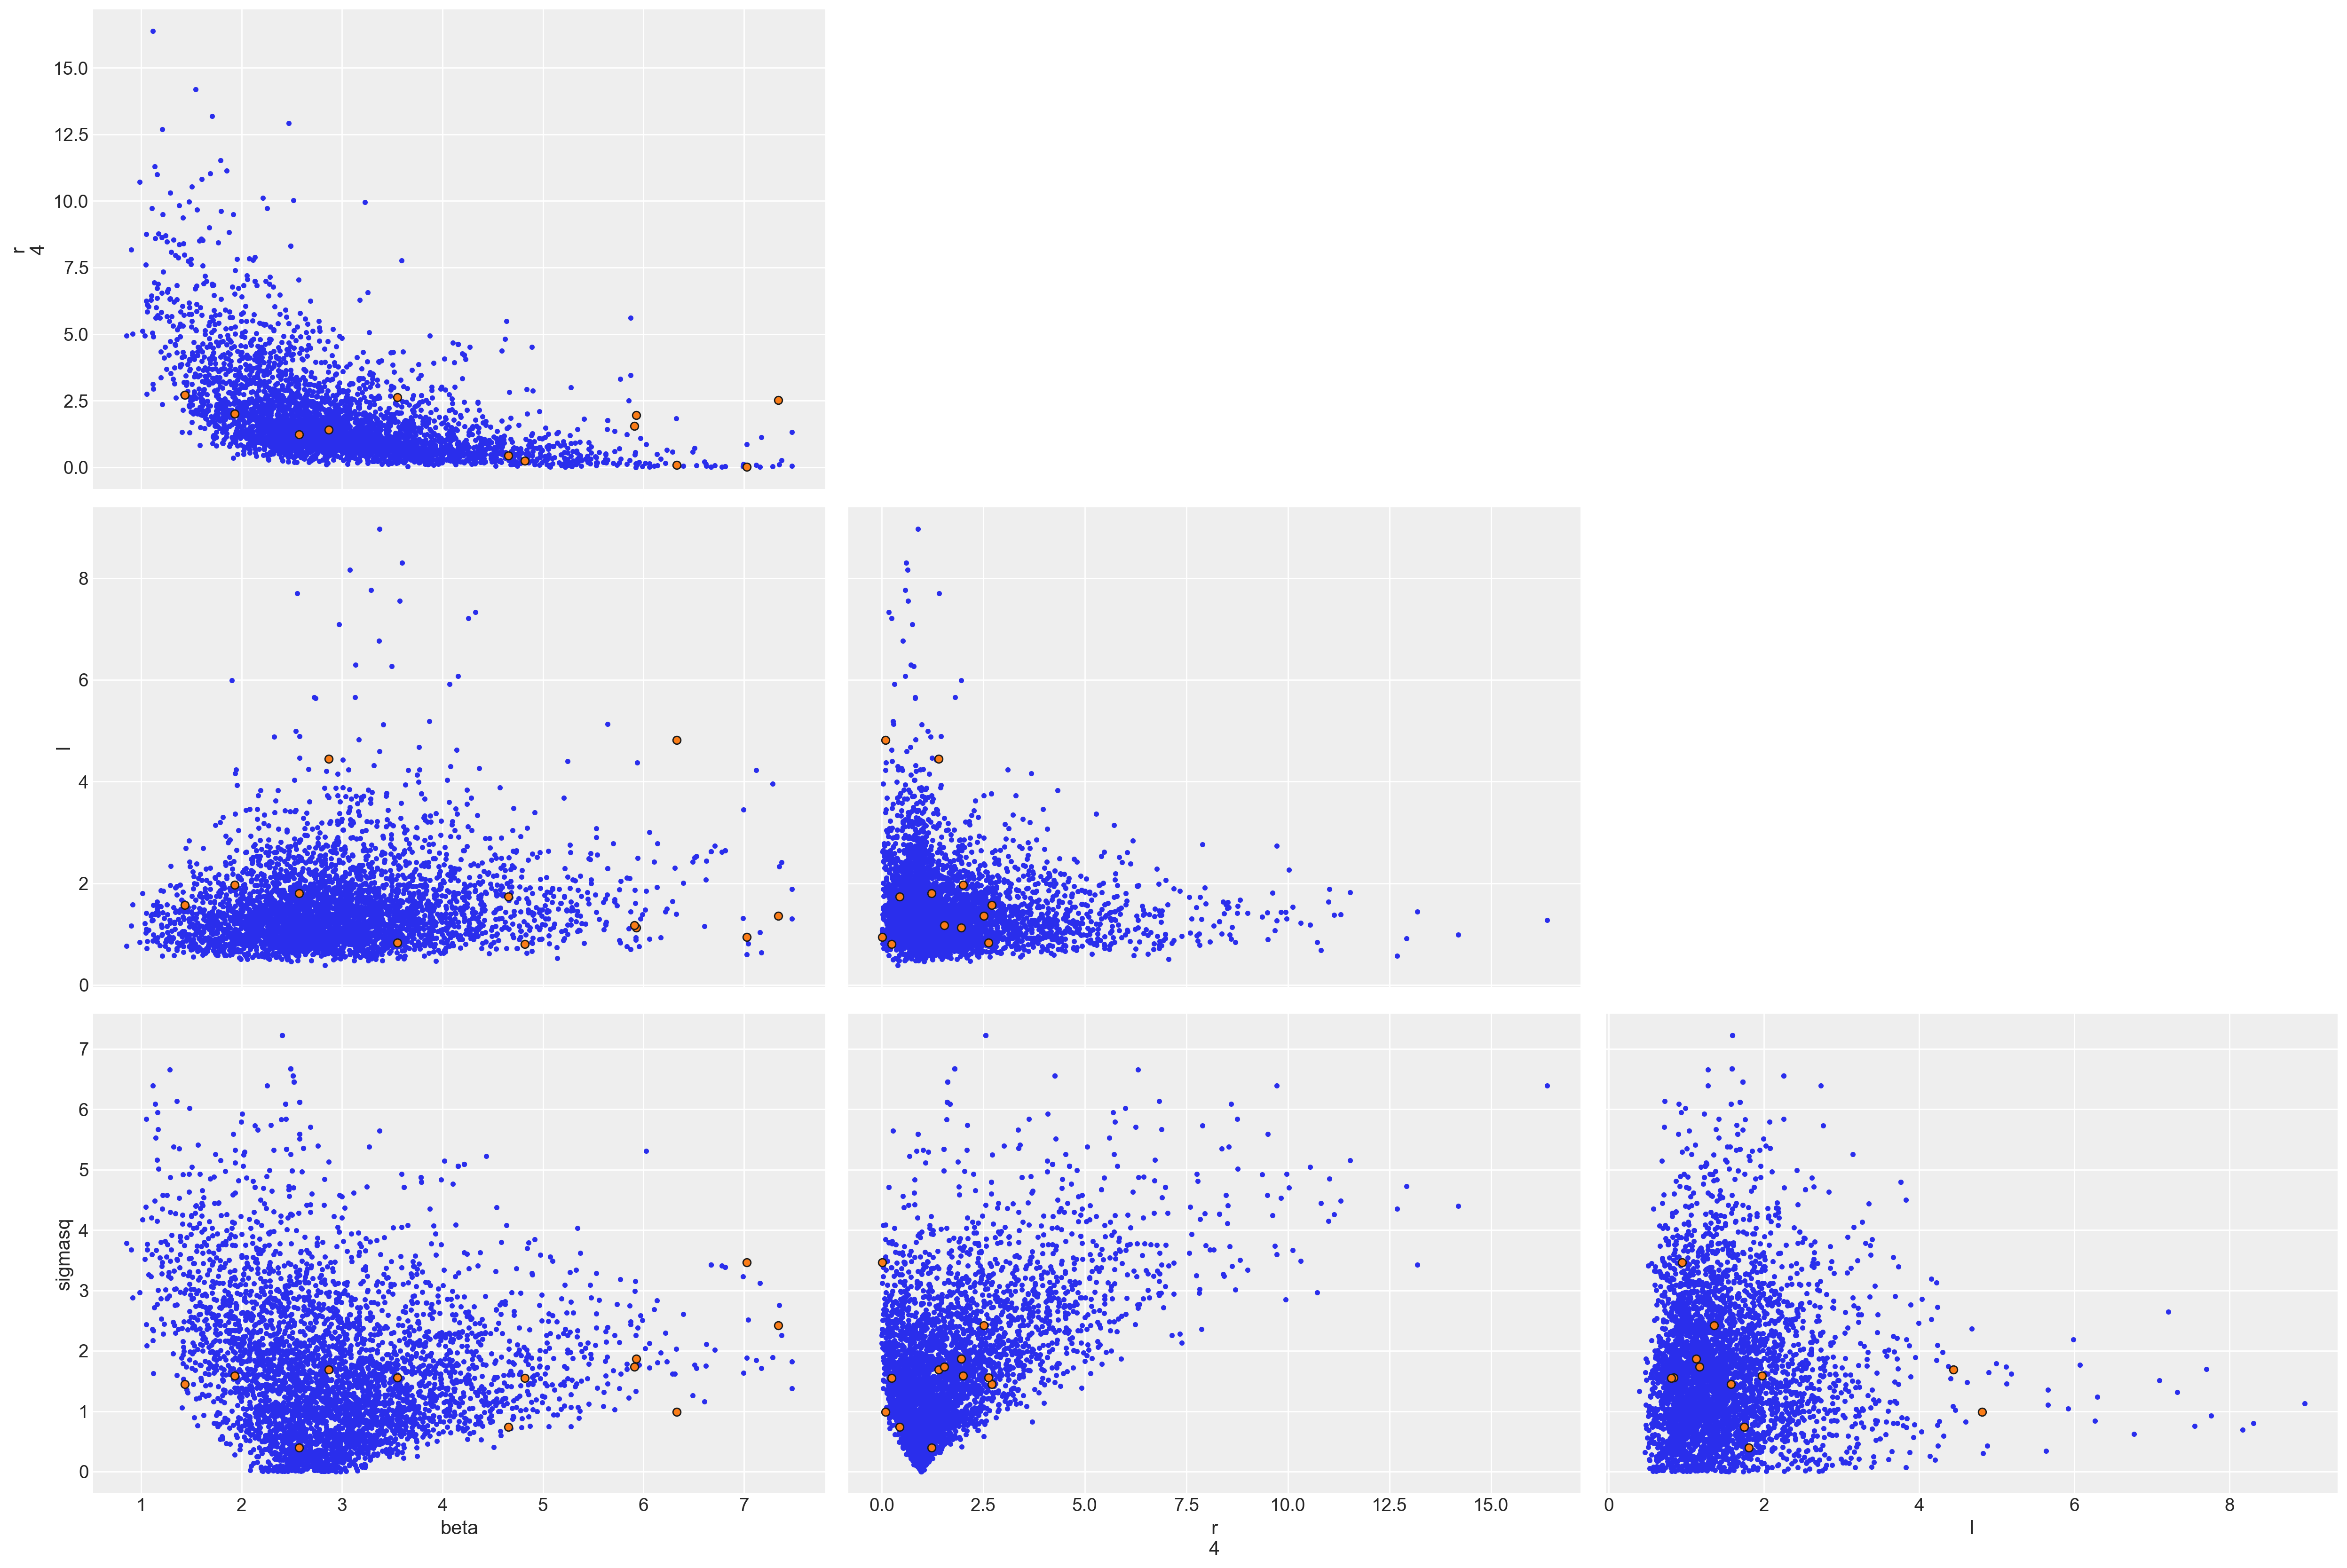

In [59]:

#az.plot_pair(samples_az, var_names=["beta", "r"], coords={"r_dim_0":[1,2]}, divergences=True)
#az.plot_pair(samples_az, var_names=["r"], coords={"r_dim_0":[0,1,2,3]}, divergences=True)
az.plot_pair(samples_az, var_names=["beta","r", "l", "sigmasq"], coords={"r_dim_0":[4]}, divergences=True);

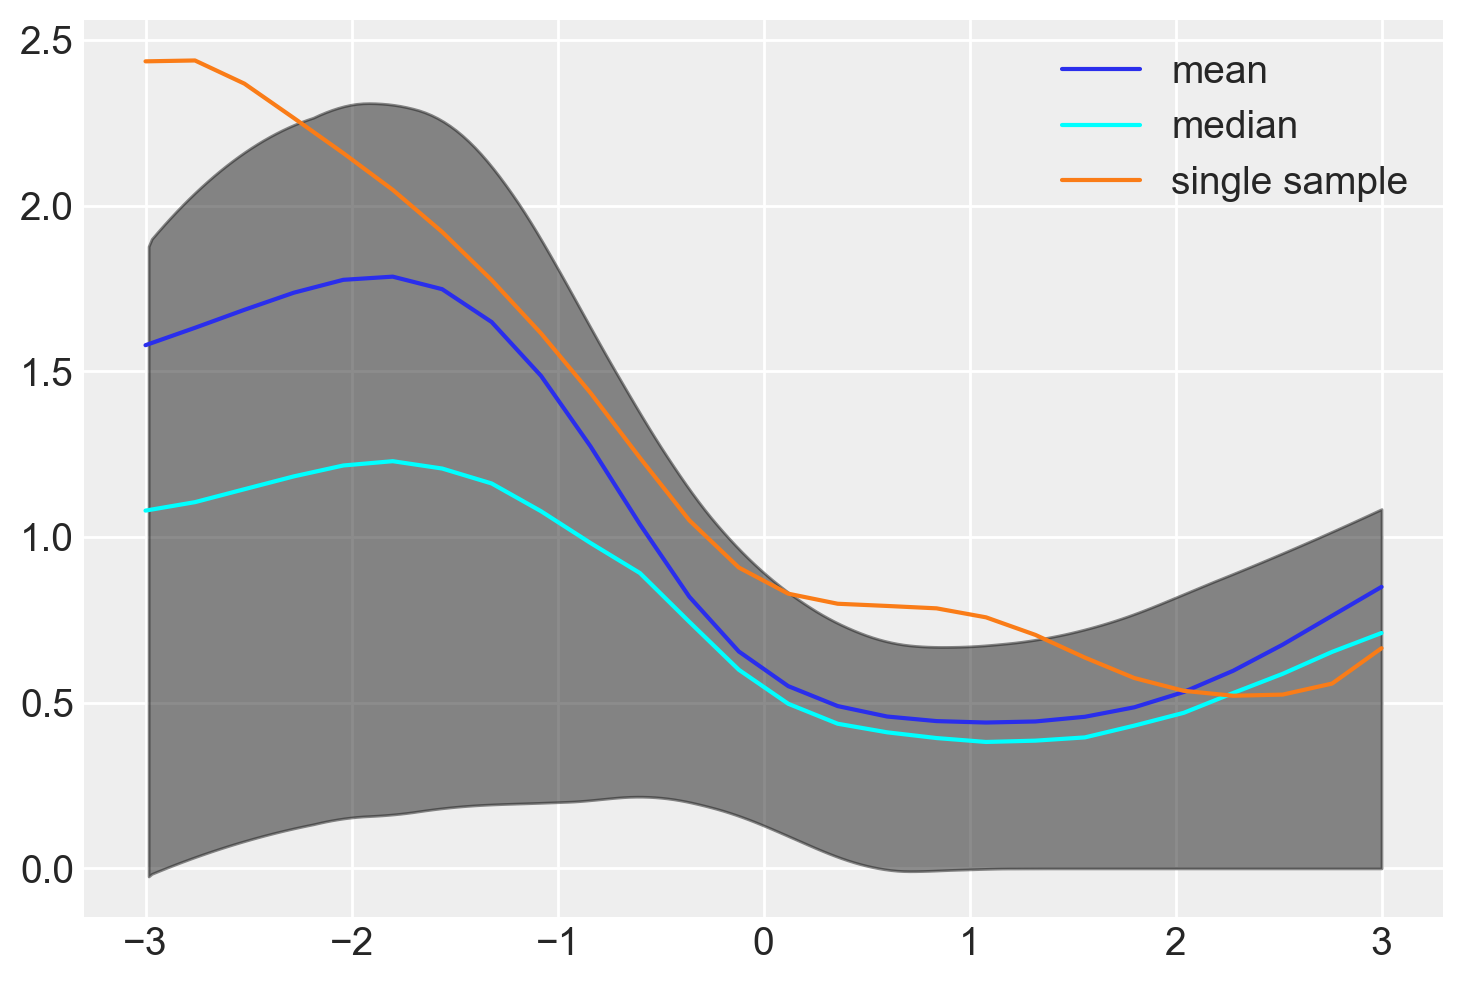

In [60]:
#az.plot_trace(samples, "beta", divergences=True)
#az.plot_trace(samples, "l", divergences=True)
#az.plot_trace(samples, "sigmasq", divergences=True)
#az.plot_trace(samples, "r", divergences=True, coords={"r_dim_0":[0]})
#plt.savefig("asd.jpg")

# az.style.use("arviz-darkgrid")
#az.plot_hdi(x_eval, samples["r"], color="k")
az.plot_hdi(x_eval, r_samples, color="k", hdi_prob=0.75)
plt.plot(x_eval, r_mean, label="mean")
plt.plot(x_eval, r_median, color="cyan", label="median")
plt.plot(x_eval, r_samples.mean(axis=0)[np.random.choice(100, 1).item()], label="single sample")
plt.legend();

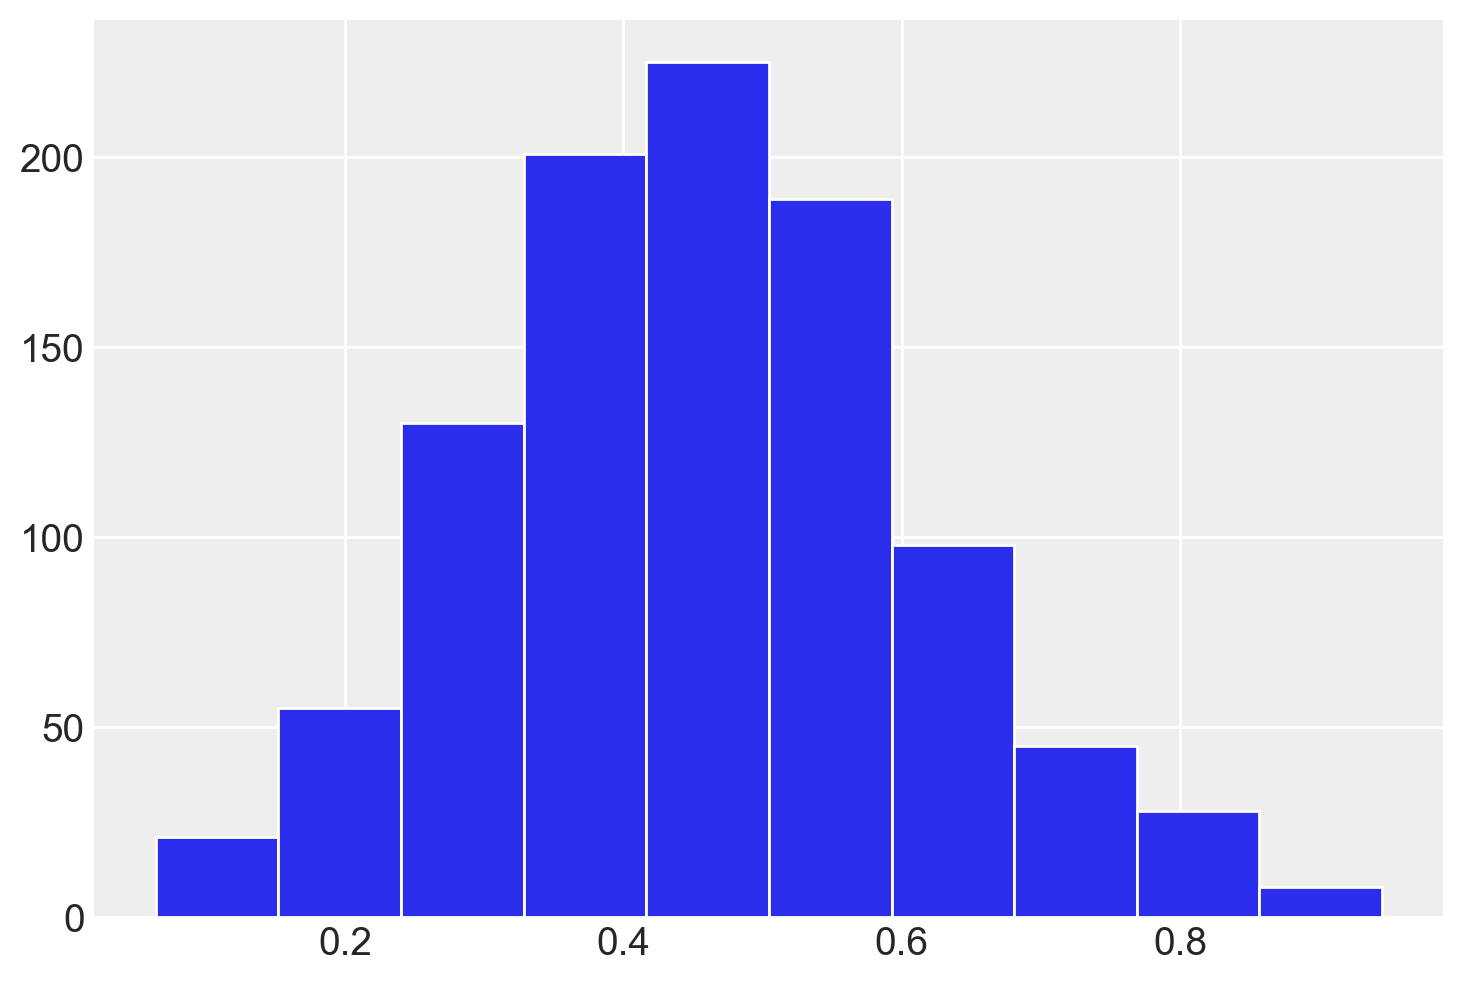

In [44]:
plt.hist(r_samples.mean(axis=0)[:,15]);

In [48]:
softplus = lambda x: np.log(np.exp(x) + 1.)
softplus_inv = lambda x: np.log(np.exp(x)-1.)#not sure about this

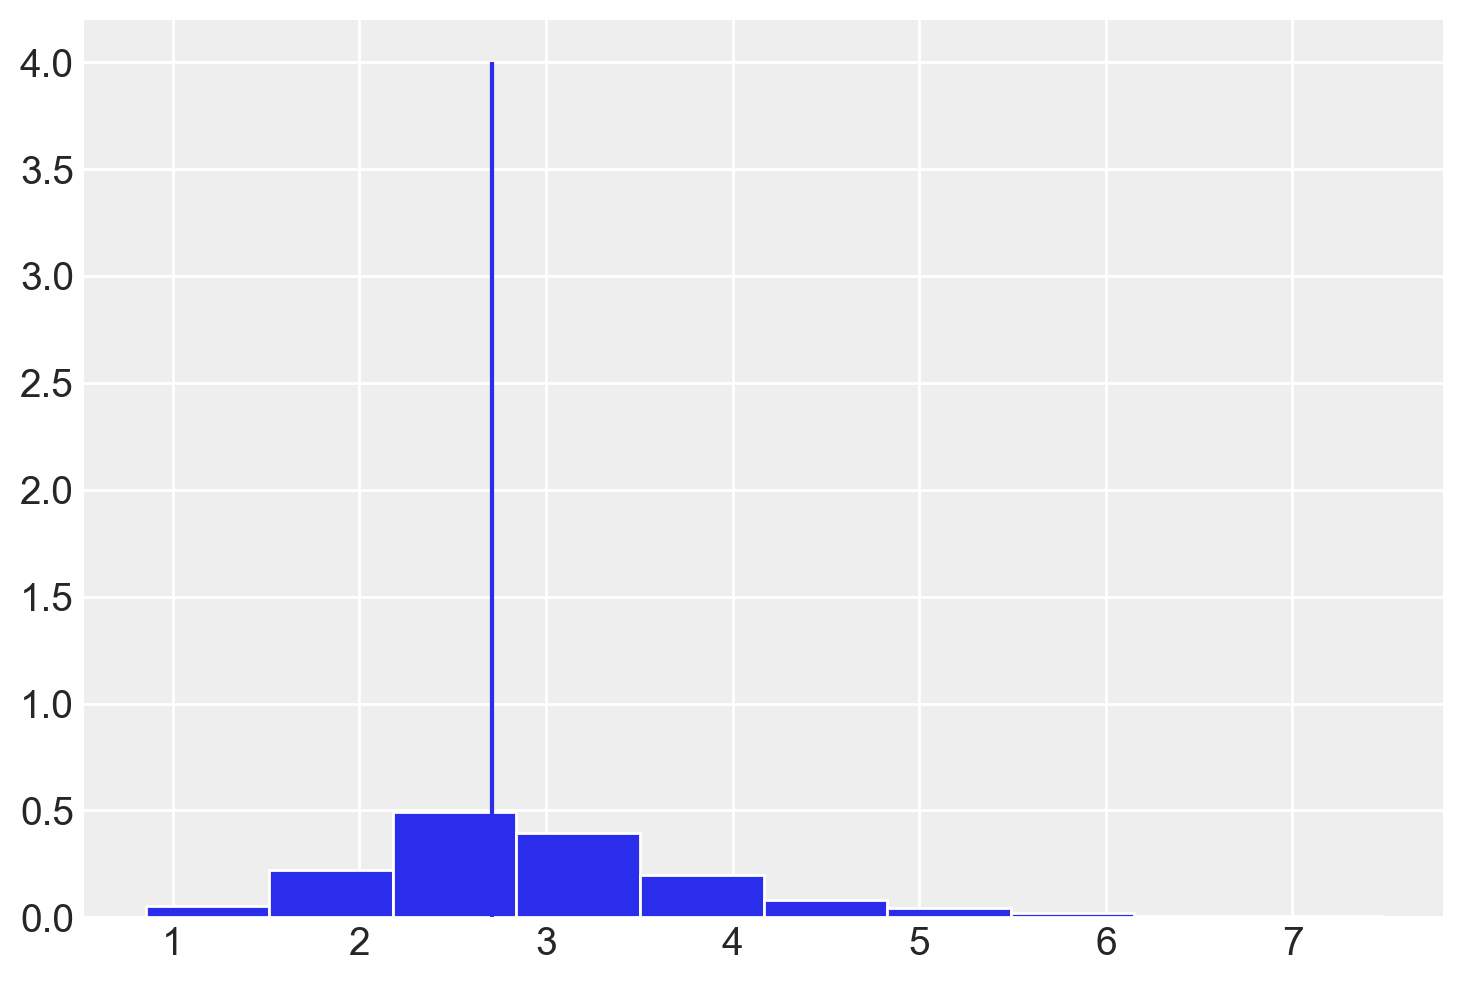

In [63]:
import torch
xxx = torch.arange(0, 4, 0.1)
prior_dist = torch.distributions.Gamma(torch.tensor(prior_shape), torch.tensor(prior_rate))
plt.hist(samples.stan_variable("beta"), density=True)
# plt.plot(xxx, prior_dist.log_prob(xxx).exp())
plt.vlines(beta_real, 0, 4)
plt.show()

In [65]:
print(np.mean(samples.stan_variable("beta")))
print(np.median(samples.stan_variable("beta")))

2.9699388799999995
2.83182


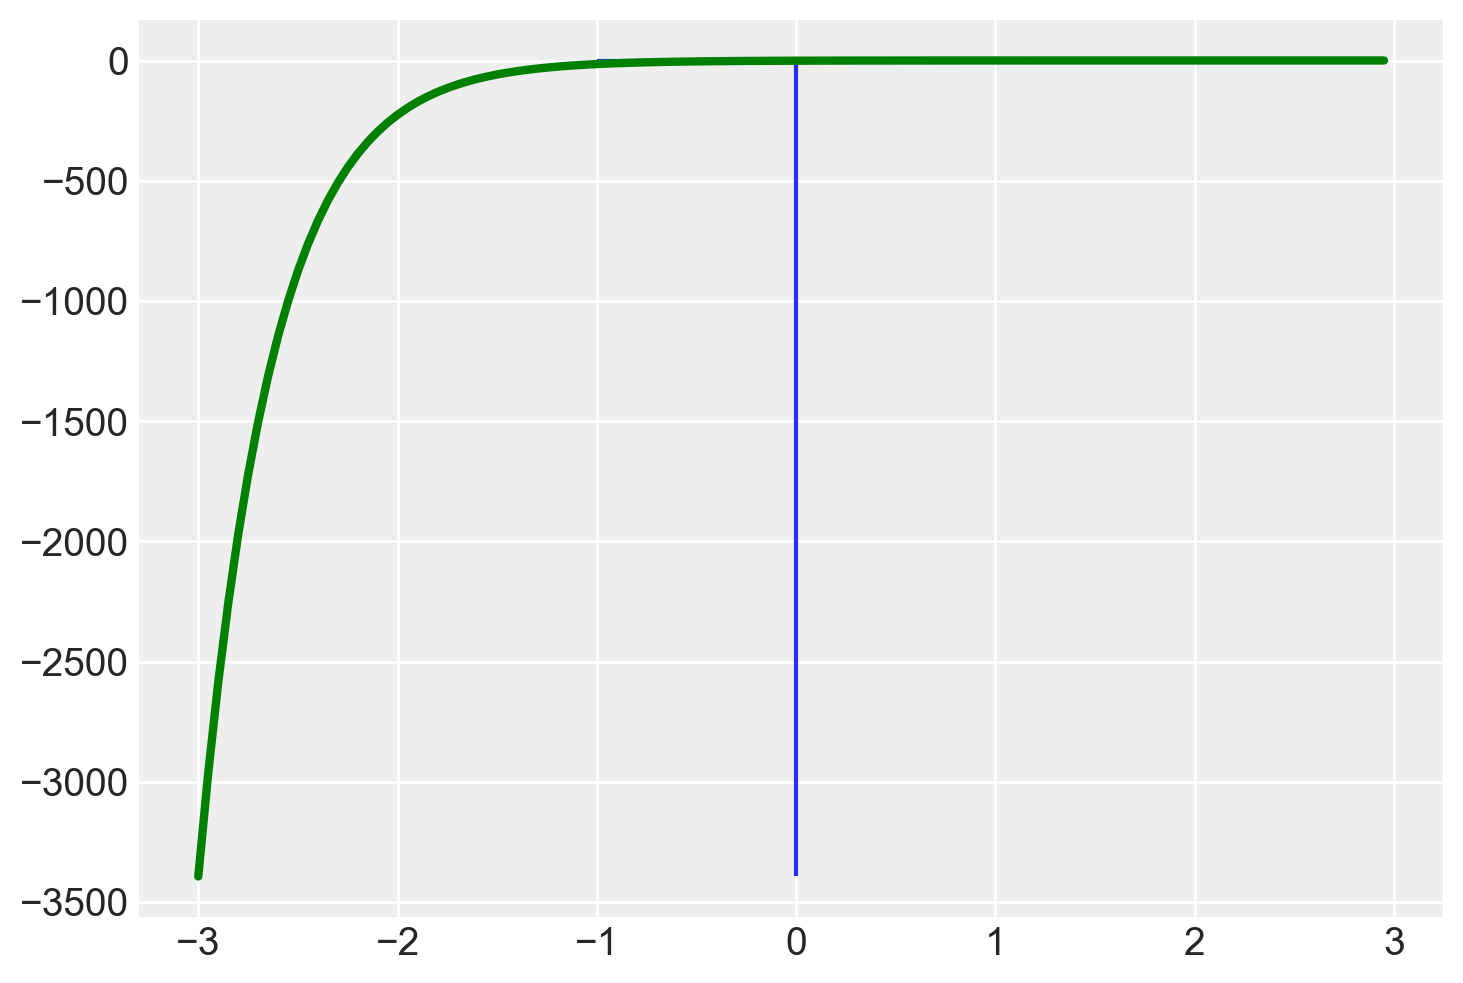

In [66]:
xx = np.arange(-3,3, 0.05)
u_generator = lambda beta: (lambda x: 1 - np.exp(-beta*x))
plt.plot(xx, u_data(xx), color="green", linewidth=3, zorder= 100, label="generating")
plt.hlines(0, -1, 1)
plt.vlines(0, np.min(u_data(xx)), np.max(u_data(xx)))

In [67]:
#GP related
import scipy.spatial.distance as dlib

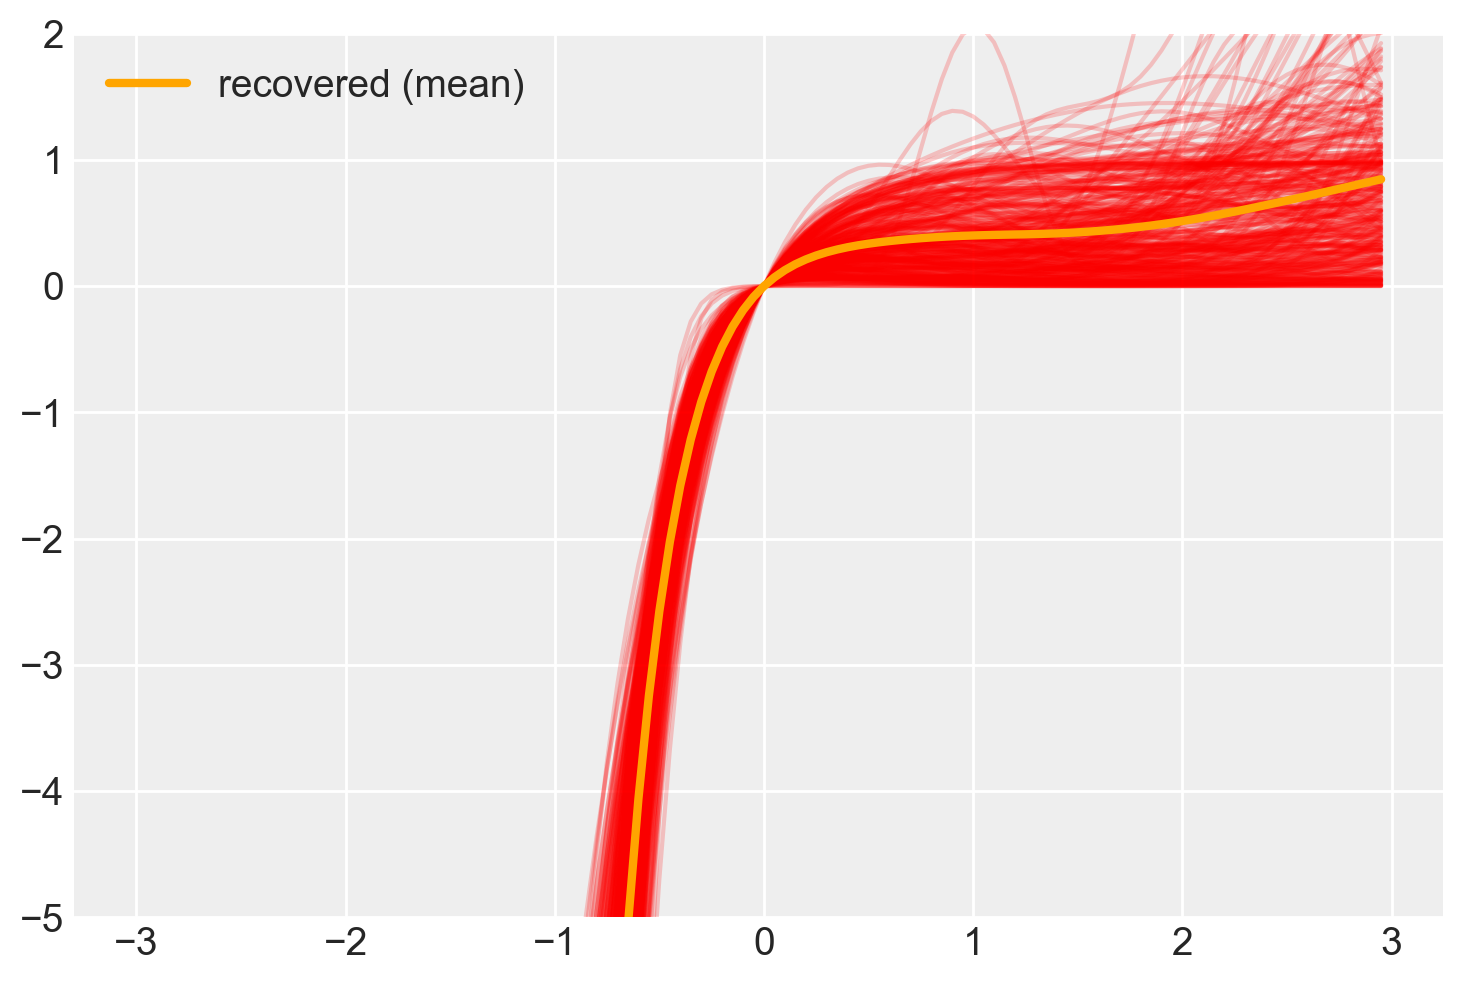

In [71]:
dist_eval = dlib.pdist(x_eval.reshape(-1, 1))
dist_eval = dlib.squareform(dist_eval)
dist_pred = dlib.cdist(xx.reshape(-1,1), x_eval.reshape(-1, 1))
squared_exp = lambda dd, lengthscale, sigmasq: sigmasq * np.exp(-0.5 * dd**2 / lengthscale**2)
jitter = 1e-8
I_jitter = jitter * np.eye(N_eval)
#plot
u_mean = np.zeros(len(xx))
N_samples = 350
for ii in range(N_samples):
    #theoretical model
    try:
        M_sample = u_generator(samples.stan_variable("beta")[ii])
    except:
        M_sample = u_generator(beta_real)
    #covariances
    l_sample = samples.stan_variable("l")[ii]
    sigmasq_sample = samples.stan_variable("sigmasq")[ii]
    K_eval = squared_exp(dist_eval, l_sample, sigmasq_sample) + I_jitter
    K_pred = squared_exp(dist_pred, l_sample, sigmasq_sample)
    #other stuff
    r_sample = samples.stan_variable("r")[ii]#todo inverse map?
    r_sample_unc = softplus_inv(r_sample)
    r_pred_unc = 0.5 + K_pred @ np.linalg.inv(K_eval) @ (r_sample_unc - 0.5)#assume 1.0 mean
    r_pred = softplus(r_pred_unc)
    ux = M_sample(xx) * r_pred
    u_mean += ux #accumulate mean
    plt.plot(xx, ux, color="red", alpha=0.2)
    # plt.plot(x_eval, softplus_inv(samples["r"]).mean(axis=0), color="orange", linewidth=4)
    # plt.plot(x_eval, r_sample_unc, color="red", alpha=0.1)
    # plt.plot(xx, r_pred_unc, color="red", alpha=0.1)

u_mean = u_mean / N_samples
plt.plot(xx, u_mean, color="orange", linewidth=3, label="recovered (mean)")
plt.ylim(-5,2)
plt.legend()